# Trading Strategies powered by Machine Learning - Regression

## Linear Regression with scikit-learn - a Multiple Introduction

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from ML_Regression import ML_Regression
from util.Save_result_return import save_to_csv

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use("seaborn-v0_8")

In [4]:
from backtesting import Strategy

## Getting the Data

In [5]:
XAUUSD = load_data()

In [6]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [7]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


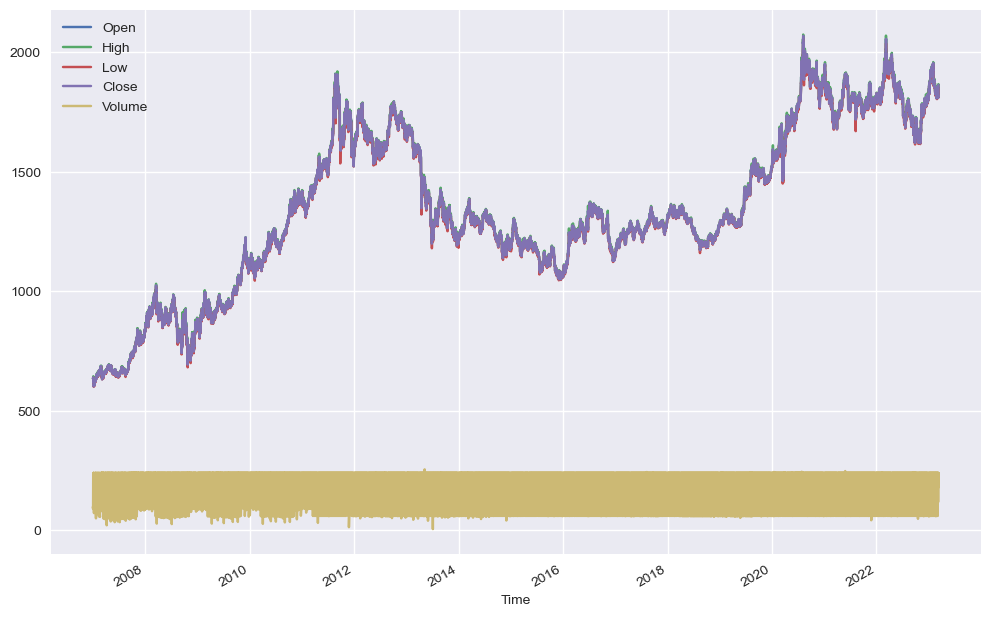

In [8]:
XAUUSD['H4'].plot(figsize = (12, 8))
plt.show()

## ML

### Class and Strategy ML

In [9]:
class Mutiple_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred[-1] == 1:
            if not self.position:
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)

        elif self.data.pred[-1] == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

In [10]:
strategy = Mutiple_Regression
account_size = 10000

In [11]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from util.Save_result_return import save_to_csv
import sys
sys.path.append('../../')


plt.style.use("seaborn-v0_8")


class ML_Regression():

    def __init__(self, data, strategy, start_train, start_test, end_train, end_test, TF):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.start_test = start_test
        self.end_train = end_train
        self.end_test = end_test
        self.TF = TF
        self.data_train = None
        self.data_test = None
        self.results = None
        self.model = None

    def Prepare(self, lags=5):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        data["returns_signal"] = data["returns"].shift(-1)
        data.dropna(inplace=True)
        cols = []

        for lag in range(lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)

        lm = LinearRegression(fit_intercept=True)
        lm.fit(data[cols], data['returns_signal'])
        data["pred"] = lm.predict(data[cols])
        data['pred'] = np.sign(data['pred'])

        self.model = lm
        self.data_train = data

    def Predict(self, lags=5):
        data = self.data.loc[self.start_test:self.end_test].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        cols = []

        for lag in range(lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)

        data["pred"] = self.model.predict(data[cols])
        data['pred'] = np.sign(data['pred'])

        self.data_test = data

    def Backtest(self, data, account_size=10000):
        # Assuming you have a Backtest class that performs backtesting
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1/100, commission=0.0002)
        result = backtest.run()
        return result


    def Run(self):
        self.Prepare()
        result_train = self.Backtest(self.data_train)

        self.Predict()
        result_test = self.Backtest(self.data_test)
       
        return result_train, result_test

## TF D1

In [12]:
data = XAUUSD['D1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'D1'

In [13]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [14]:
train , test = ml.Run()

### In-Sample Backtesting

In [15]:
train

Start                     2007-01-08 00:00:00
End                       2019-12-30 00:00:00
Duration                   4739 days 00:00:00
Exposure Time [%]                   99.950556
Equity Final [$]                 10772.116172
Equity Peak [$]                  11389.102871
Return [%]                           7.721162
Buy & Hold Return [%]              148.689509
Return (Ann.) [%]                     0.46443
Volatility (Ann.) [%]                1.764185
Sharpe Ratio                         0.263255
Sortino Ratio                         0.37745
Calmar Ratio                          0.07267
Max. Drawdown [%]                   -6.390991
Avg. Drawdown [%]                   -0.494117
Max. Drawdown Duration     1992 days 00:00:00
Avg. Drawdown Duration       62 days 00:00:00
# Trades                                 1572
Win Rate [%]                        50.508906
Best Trade [%]                      10.595437
Worst Trade [%]                    -11.757799
Avg. Trade [%]                    

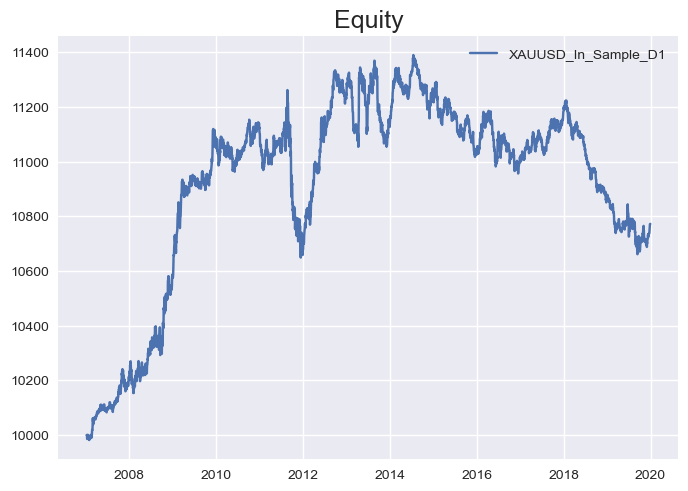

In [16]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [17]:
test

Start                     2020-01-08 00:00:00
End                       2023-03-10 00:00:00
Duration                   1157 days 00:00:00
Exposure Time [%]                   99.796954
Equity Final [$]                  9054.938493
Equity Peak [$]                  10074.088142
Return [%]                          -9.450615
Buy & Hold Return [%]               19.648007
Return (Ann.) [%]                    -2.50784
Volatility (Ann.) [%]                2.725789
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -11.94004
Avg. Drawdown [%]                   -4.119801
Max. Drawdown Duration     1114 days 00:00:00
Avg. Drawdown Duration      382 days 00:00:00
# Trades                                  402
Win Rate [%]                        45.024876
Best Trade [%]                       4.740962
Worst Trade [%]                     -5.408013
Avg. Trade [%]                    

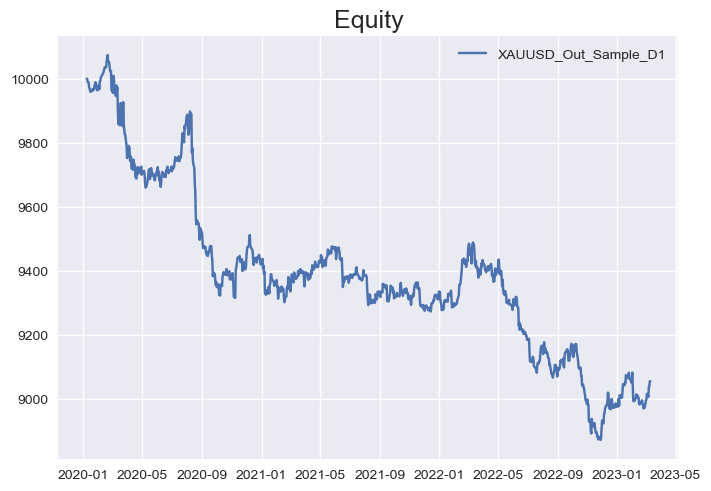

In [18]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [19]:
filename_train = f'result_{TF}_In_Sample.csv'

In [20]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [21]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [22]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF H4

In [23]:
data = XAUUSD['H4']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H4'

In [24]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [25]:
train , test = ml.Run()

### In-Sample Backtesting

In [26]:
train

Start                     2007-01-02 00:00:00
End                       2019-12-31 16:00:00
Duration                   4746 days 16:00:00
Exposure Time [%]                   99.990414
Equity Final [$]                 11105.617177
Equity Peak [$]                  12119.543287
Return [%]                          11.056172
Buy & Hold Return [%]              138.448093
Return (Ann.) [%]                    0.654266
Volatility (Ann.) [%]                1.670001
Sharpe Ratio                         0.391776
Sortino Ratio                        0.585631
Calmar Ratio                         0.077231
Max. Drawdown [%]                   -8.471575
Avg. Drawdown [%]                   -0.196378
Max. Drawdown Duration     2805 days 04:00:00
Avg. Drawdown Duration       16 days 14:00:00
# Trades                                 9769
Win Rate [%]                         49.73897
Best Trade [%]                      10.621409
Worst Trade [%]                     -6.274439
Avg. Trade [%]                    

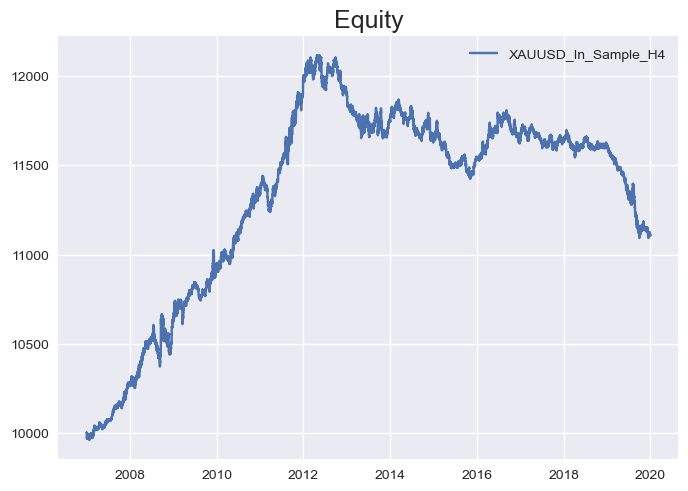

In [27]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [28]:
test

Start                     2020-01-02 20:00:00
End                       2023-03-10 16:00:00
Duration                   1162 days 20:00:00
Exposure Time [%]                   99.960777
Equity Final [$]                  8952.269856
Equity Peak [$]                  10127.841597
Return [%]                         -10.477301
Buy & Hold Return [%]               21.937846
Return (Ann.) [%]                   -2.777943
Volatility (Ann.) [%]                2.516406
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -11.782184
Avg. Drawdown [%]                   -1.715053
Max. Drawdown Duration      945 days 08:00:00
Avg. Drawdown Duration      128 days 17:00:00
# Trades                                 2366
Win Rate [%]                        48.393914
Best Trade [%]                       3.510538
Worst Trade [%]                     -5.383073
Avg. Trade [%]                    

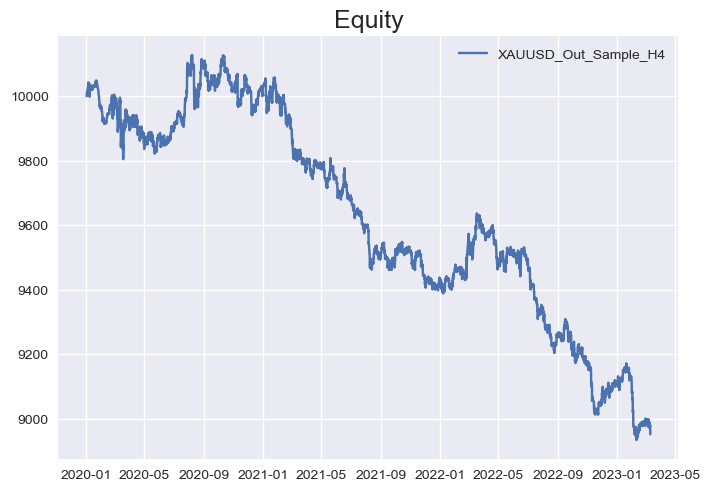

In [29]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [30]:
filename_train = f'result_{TF}_In_Sample.csv'

In [31]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [32]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [33]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF H1

In [34]:
data = XAUUSD['H1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H1'

In [35]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [36]:
train , test = ml.Run()

### In-Sample Backtesting

In [37]:
train

Start                     2007-01-01 06:00:00
End                       2019-12-31 20:00:00
Duration                   4747 days 14:00:00
Exposure Time [%]                   99.997471
Equity Final [$]                  6802.933492
Equity Peak [$]                  10130.968836
Return [%]                         -31.970665
Buy & Hold Return [%]              138.749634
Return (Ann.) [%]                   -2.367361
Volatility (Ann.) [%]                2.064531
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -33.663916
Avg. Drawdown [%]                    -0.82812
Max. Drawdown Duration     4344 days 04:00:00
Avg. Drawdown Duration      101 days 00:00:00
# Trades                                17865
Win Rate [%]                        52.555276
Best Trade [%]                        6.23535
Worst Trade [%]                     -8.552351
Avg. Trade [%]                    

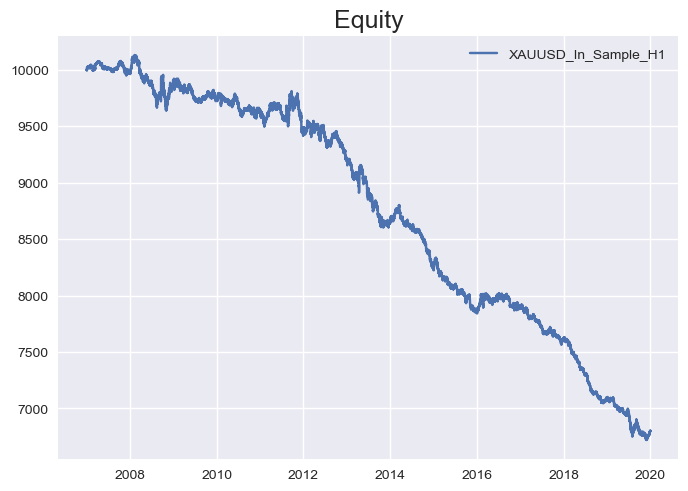

In [38]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [39]:
test

Start                     2020-01-02 05:00:00
End                       2023-03-10 17:00:00
Duration                   1163 days 12:00:00
Exposure Time [%]                   99.989394
Equity Final [$]                  8970.887441
Equity Peak [$]                  10299.232879
Return [%]                         -10.291126
Buy & Hold Return [%]               22.623102
Return (Ann.) [%]                   -2.753246
Volatility (Ann.) [%]                2.470596
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -13.251293
Avg. Drawdown [%]                   -0.404769
Max. Drawdown Duration      945 days 22:00:00
Avg. Drawdown Duration       20 days 01:00:00
# Trades                                 4458
Win Rate [%]                        53.790938
Best Trade [%]                       2.378468
Worst Trade [%]                     -4.111006
Avg. Trade [%]                    

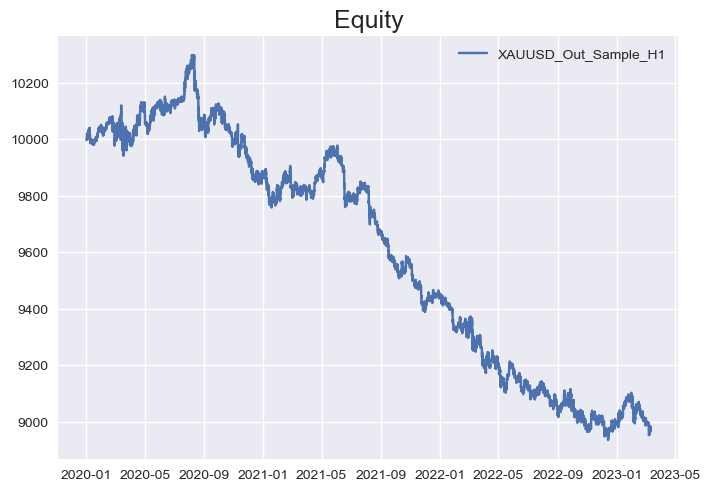

In [40]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [41]:
filename_train = f'result_{TF}_In_Sample.csv'

In [42]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [43]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [44]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF M30

In [45]:
data = XAUUSD['M30']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M30'

In [46]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [47]:
train , test = ml.Run()

### In-Sample Backtesting

In [48]:
train

Start                     2007-01-01 03:00:00
End                       2019-12-31 21:00:00
Duration                   4747 days 18:00:00
Exposure Time [%]                   72.100258
Equity Final [$]                     8.478094
Equity Peak [$]                  10010.363219
Return [%]                         -99.915219
Buy & Hold Return [%]              138.820778
Return (Ann.) [%]                  -35.587868
Volatility (Ann.) [%]               17.096536
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.940181
Avg. Drawdown [%]                   -7.724608
Max. Drawdown Duration     4738 days 05:00:00
Avg. Drawdown Duration      365 days 04:47:00
# Trades                                47192
Win Rate [%]                        49.076115
Best Trade [%]                       3.093445
Worst Trade [%]                     -9.600389
Avg. Trade [%]                    

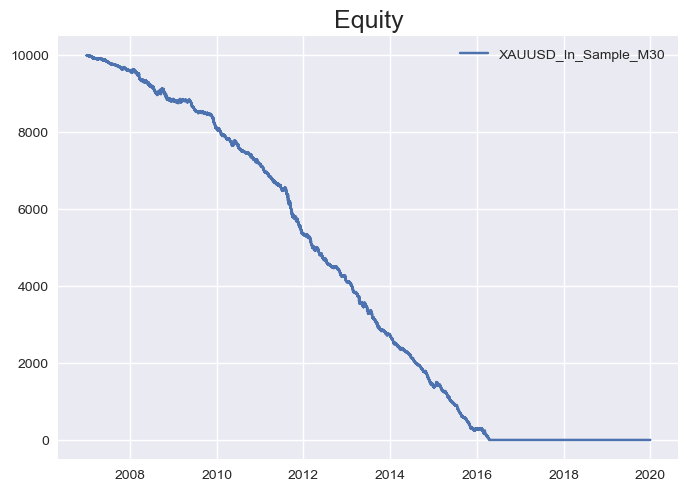

In [49]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [50]:
test

Start                     2020-01-02 02:00:00
End                       2023-03-10 17:30:00
Duration                   1163 days 15:30:00
Exposure Time [%]                   99.994696
Equity Final [$]                  5667.469807
Equity Peak [$]                  10022.206528
Return [%]                         -43.325302
Buy & Hold Return [%]                22.67717
Return (Ann.) [%]                  -13.441429
Volatility (Ann.) [%]                2.847181
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -43.450878
Avg. Drawdown [%]                   -6.290433
Max. Drawdown Duration     1157 days 09:30:00
Avg. Drawdown Duration      166 days 05:22:00
# Trades                                15449
Win Rate [%]                        49.647226
Best Trade [%]                       2.036804
Worst Trade [%]                     -4.619286
Avg. Trade [%]                    

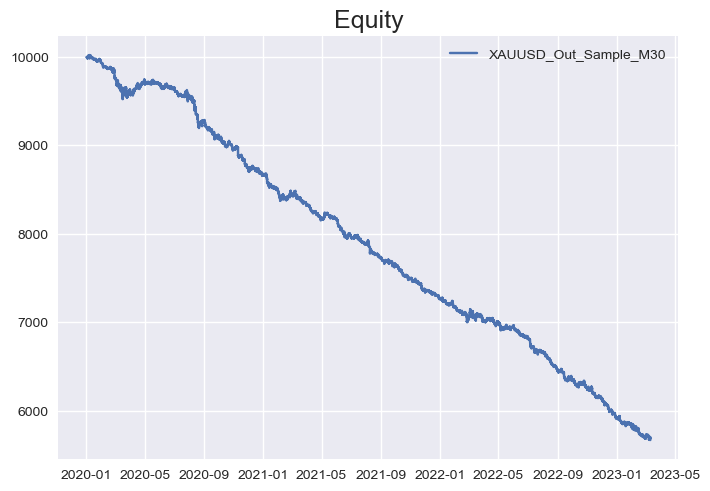

In [51]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [52]:
filename_train = f'result_{TF}_In_Sample.csv'

In [53]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [54]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [55]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF M15

In [56]:
data = XAUUSD['M15']
start_train = '2014'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M15'

In [57]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [58]:
train , test = ml.Run()

### In-Sample Backtesting

In [59]:
train

Start                     2014-09-23 14:30:00
End                       2019-12-31 21:30:00
Duration                   1925 days 07:00:00
Exposure Time [%]                   84.384734
Equity Final [$]                    11.812189
Equity Peak [$]                  10000.377007
Return [%]                         -99.881878
Buy & Hold Return [%]               24.218093
Return (Ann.) [%]                  -64.506293
Volatility (Ann.) [%]               11.807957
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.881883
Avg. Drawdown [%]                  -33.295664
Max. Drawdown Duration     1925 days 05:30:00
Avg. Drawdown Duration      641 days 18:15:00
# Trades                                44143
Win Rate [%]                        45.157783
Best Trade [%]                       1.878122
Worst Trade [%]                     -2.518568
Avg. Trade [%]                    

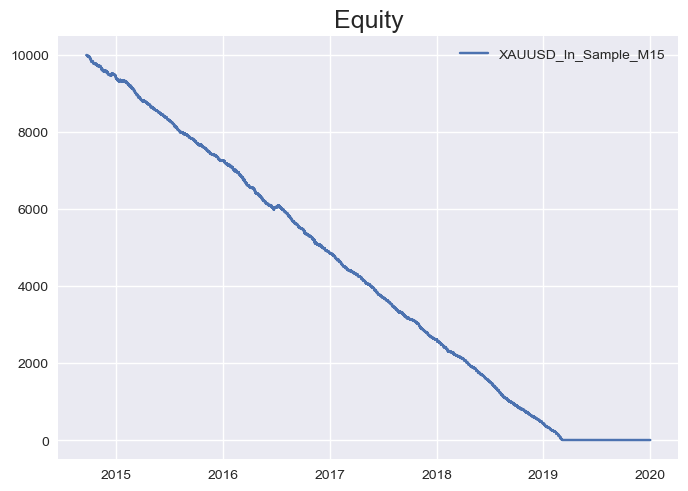

In [60]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [61]:
test

Start                     2020-01-02 00:30:00
End                       2023-03-10 17:45:00
Duration                   1163 days 17:15:00
Exposure Time [%]                   99.070575
Equity Final [$]                    17.499261
Equity Peak [$]                  10001.139292
Return [%]                         -99.825007
Buy & Hold Return [%]               22.768468
Return (Ann.) [%]                  -80.120711
Volatility (Ann.) [%]               10.545628
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.825027
Avg. Drawdown [%]                  -99.825027
Max. Drawdown Duration     1163 days 16:15:00
Avg. Drawdown Duration     1163 days 16:15:00
# Trades                                31862
Win Rate [%]                        48.666123
Best Trade [%]                       2.015583
Worst Trade [%]                     -3.448342
Avg. Trade [%]                    

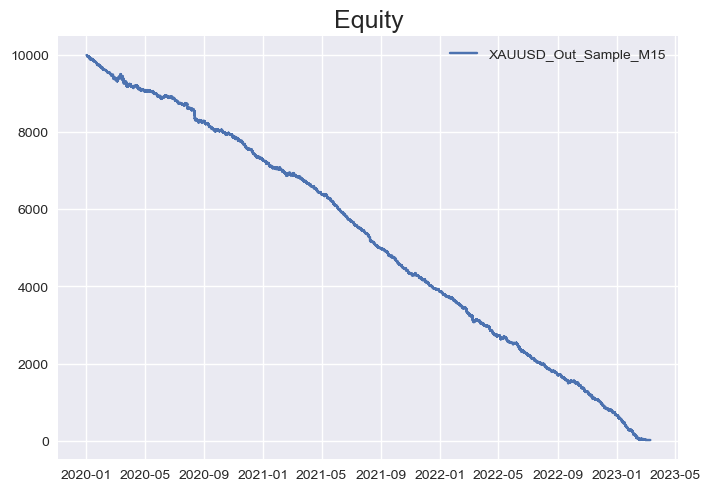

In [62]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [63]:
filename_train = f'result_{TF}_In_Sample.csv'

In [64]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF M5

In [ ]:
data = XAUUSD['M5']
start_train = '2020'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M5'

In [ ]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [ ]:
train , test = ml.Run()

### In-Sample Backtesting

In [ ]:
train

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF M1

In [ ]:
data = XAUUSD['M1']
start_train = '2022'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M1'

In [ ]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [ ]:
train , test = ml.Run()

### In-Sample Backtesting

In [ ]:
train

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')